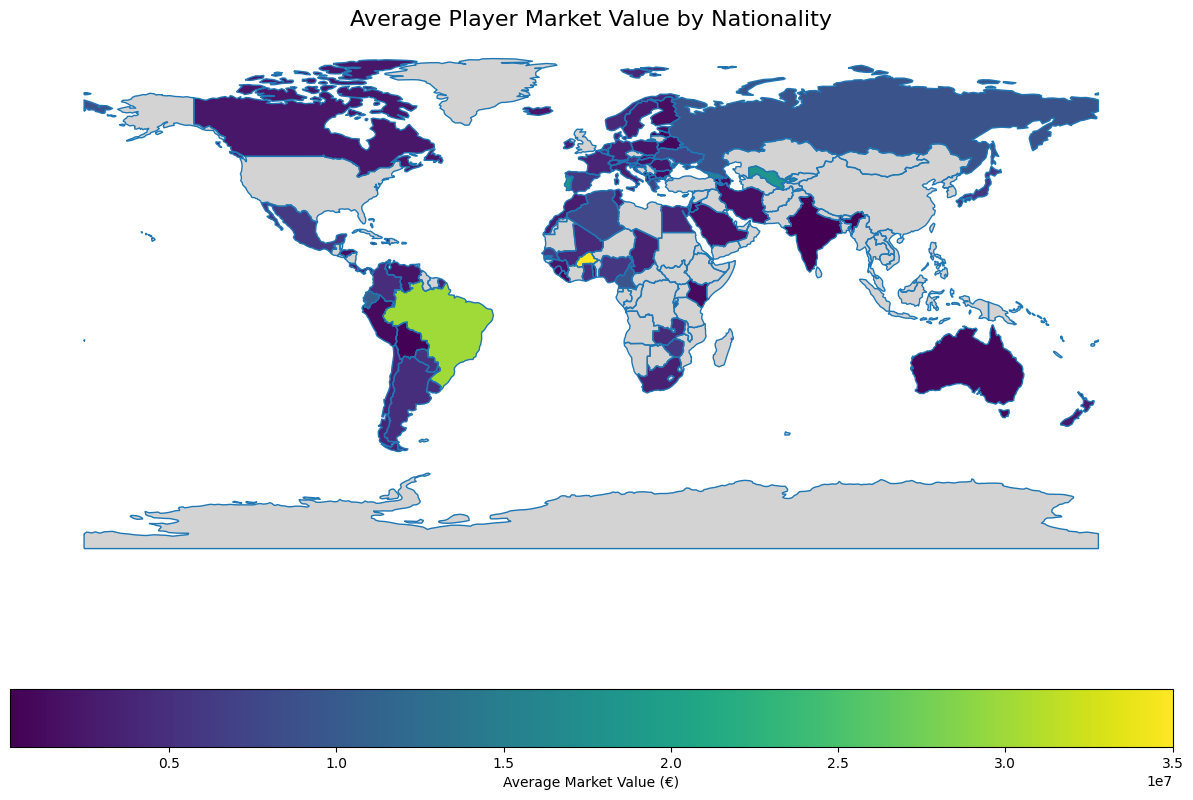

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd

# 1. Load Data
df = pd.read_csv('../../Data/Merged/football_data_cleaned.csv')
country_stats = df.groupby('nationality')['market_value_eur'].mean().reset_index()
country_stats.columns = ['name', 'avg_market_value']

# 3. FIX: Load World Map Data directly from a URL instead of the deprecated function
# This URL points to the standard "Natural Earth" low-resolution country boundaries
url = "https://naturalearth.s3.amazonaws.com/110m_cultural/ne_110m_admin_0_countries.zip"
world = gpd.read_file(url)

# 4. Merge Data
# Note: The column in Natural Earth data is usually 'ADMIN' or 'NAME'
# Let's check the columns or just rename 'ADMIN' to 'name' for the merge
world = world.rename(columns={'ADMIN': 'name'})

world_data = world.merge(country_stats, on='name', how='left')

# 5. Plot the Map
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
world_data.boundary.plot(ax=ax, linewidth=1)
world_data.plot(
    column='avg_market_value', 
    ax=ax, 
    legend=True,
    legend_kwds={'label': "Average Market Value (€)", 'orientation': "horizontal"},
    cmap='viridis', 
    missing_kwds={'color': 'lightgrey'}
)

plt.title('Average Player Market Value by Nationality', fontsize=16)
plt.axis('off')
plt.show()

/tmp/ipykernel_26507/3106821068.py:48: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Value Bracket', y='Abs Error', data=results, order=['< €1M', '€1M - €10M', '€10M - €50M', '> €50M (Elite)'], palette='magma')


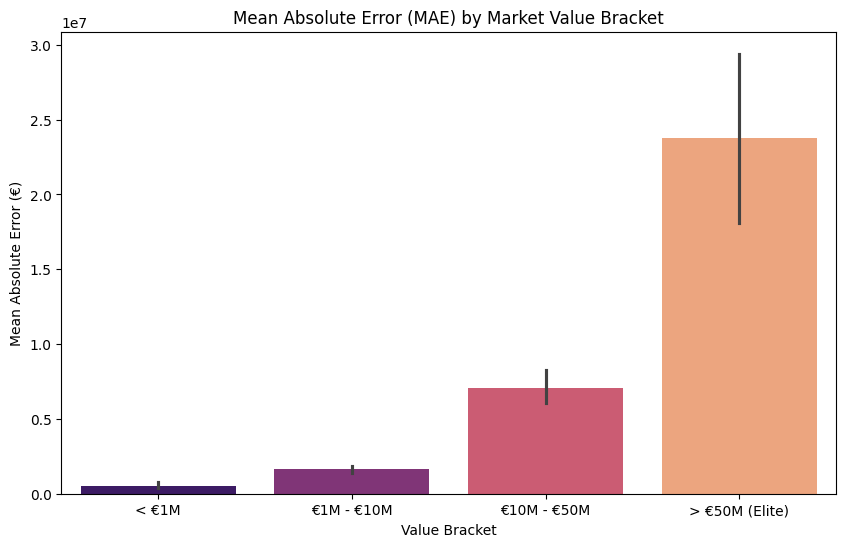

/tmp/ipykernel_26507/3106821068.py:57: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Age Group', y='% Error', data=results, palette='coolwarm', showfliers=False)


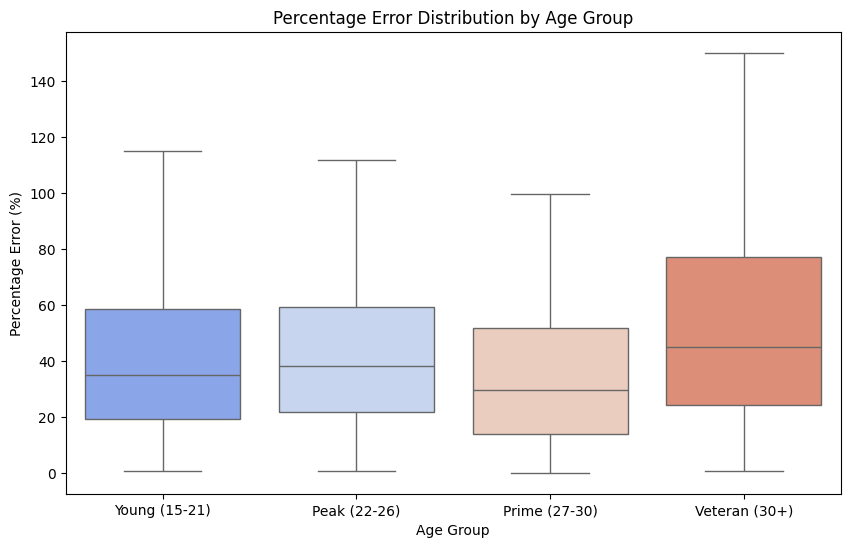

--- Best Predictions ---
      True Value  Predicted Value   % Error
3054    600000.0     5.997882e+05  0.035297
3487    500000.0     5.002345e+05  0.046907
3824    350000.0     3.503022e+05  0.086333
410    6000000.0     5.961544e+06  0.640932
3783    600000.0     5.959476e+05  0.675405

--- Model Overestimated These Players ---
    True Value  Predicted Value         Error
69    250000.0     3.268214e+07  3.243214e+07
44  50000000.0     8.011620e+07  3.011620e+07
8   10000000.0     3.537439e+07  2.537439e+07

--- Model Underestimated These Players ---
    True Value  Predicted Value         Error
33  75000000.0     3.490225e+07 -4.009775e+07
73  65000000.0     3.308453e+07 -3.191547e+07
23  70000000.0     3.841919e+07 -3.158081e+07


In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler

# 1. Load and Prepare Data
features = ['overall_rating', 'potential', 'age', 'attacking_finishing', 'skill_dribbling', 
            'movement_sprint_speed', 'power_stamina', 'mentality_interceptions', 
            'mentality_vision', 'power_shot_power'] # Add your full feature list here
target = 'market_value_eur'

# Drop missing and set up data
df = df.dropna(subset=[target] + features)
X = df[features]
y = np.log1p(df[target]) # Log transform

# 2. Train the Winner Model (Gradient Boosting)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = GradientBoostingRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# 3. Generate Predictions (Transform back to Euros)
y_pred_log = model.predict(X_test)
y_pred_eur = np.expm1(y_pred_log)
y_test_eur = np.expm1(y_test)

# Create an Analysis DataFrame
results = X_test.copy()
results['True Value'] = y_test_eur
results['Predicted Value'] = y_pred_eur
results['Error'] = results['Predicted Value'] - results['True Value']
results['Abs Error'] = results['Error'].abs()
results['% Error'] = (results['Abs Error'] / results['True Value']) * 100

# --- 9.1 Performance by Value Bracket ---
def get_bracket(val):
    if val < 1_000_000: return '< €1M'
    elif val < 10_000_000: return '€1M - €10M'
    elif val < 50_000_000: return '€10M - €50M'
    else: return '> €50M (Elite)'

results['Value Bracket'] = results['True Value'].apply(get_bracket)

plt.figure(figsize=(10, 6))
sns.barplot(x='Value Bracket', y='Abs Error', data=results, order=['< €1M', '€1M - €10M', '€10M - €50M', '> €50M (Elite)'], palette='magma')
plt.title('Mean Absolute Error (MAE) by Market Value Bracket')
plt.ylabel('Mean Absolute Error (€)')
plt.savefig('error_by_bracket.png')
plt.show()

# --- 9.3 Performance by Age Group ---
results['Age Group'] = pd.cut(results['age'], bins=[15, 21, 26, 30, 40], labels=['Young (15-21)', 'Peak (22-26)', 'Prime (27-30)', 'Veteran (30+)'])
plt.figure(figsize=(10, 6))
sns.boxplot(x='Age Group', y='% Error', data=results, palette='coolwarm', showfliers=False)
plt.title('Percentage Error Distribution by Age Group')
plt.ylabel('Percentage Error (%)')
plt.savefig('error_by_age.png')
plt.show()

# --- 9.4 Success and Failure Cases ---
# Best Predictions (Lowest % Error)
print("--- Best Predictions ---")
print(results.sort_values('% Error').head(5)[['True Value', 'Predicted Value', '% Error']])

# Worst Overestimations (Predicted >> True)
print("\n--- Model Overestimated These Players ---")
overestimated = results.sort_values('Error', ascending=False).head(3)
print(overestimated[['True Value', 'Predicted Value', 'Error']])

# Worst Underestimations (Predicted << True)
print("\n--- Model Underestimated These Players ---")
underestimated = results.sort_values('Error', ascending=True).head(3)
print(underestimated[['True Value', 'Predicted Value', 'Error']])